In [1]:
import os, re, functools, h5py
from datetime import datetime, timedelta
import numpy

from utilities.file_stream import file_source_setup
from utilities.gpst import dt2gpst
from utilities.automatic_sp3 import compute_satellite_ecf_position
from utilities.coordinates import ecf2geo, geo2ecf, ecf2sky
from utilities.hdf5_utils import write_dict_to_hdf5
from utilities.haleakala_processing_utils import get_haleakala_file_info_list, get_haleakala_source_template, \
    get_sat_segments_of_interest, HALEAKALA_APPROX_RX_GEO

import matplotlib as mpl
import matplotlib.pyplot as plt

`rarfile` package not found.  ".rar" file decompression will not be available


In [2]:
import numpy
from numpy import array, zeros, arange, sqrt, exp, conj, diag, diff, angle, identity, log10, nan
from numpy.linalg import inv
from scipy.constants import pi, c
from scipy.linalg import block_diag
from utilities.kf_dynamics import compute_2nd_order_alpha_beta_from_xi_omega, compute_2nd_order_xi_omega_from_alpha_beta, \
    compute_2nd_order_steady_state_kalman_gain, compute_3rd_order_a_b_omega_from_alpha_beta_gamma, \
    compute_3rd_order_alpha_beta_gamma_from_a_b_omega, compute_3rd_order_steady_state_kalman_gain, \
    compute_2nd_order_DLL_2nd_order_PLL_Q_matrix, compute_2nd_order_DLL_3rd_order_PLL_Q_matrix
from utilities.kf_dynamics import create_2nd_order_Q, create_3rd_order_Q
from functools import lru_cache

def track(source, signal, start_time, T_block, rho0_acq, phi0_acq, doppler_acq, tracking_duration=None, **kwargs):
    
    args = {'start_time': start_time, 'T_block': T_block, 'rho0_acq': rho0_acq, 'phi0_acq': phi0_acq, 'doppler_acq': doppler_acq}
    
    # `sync_corr_with_data_symbols` determines whether to dynamically update propagation time to stay synched with data symbols
    # will update `T_block` dynamically to be the nearest divisor of `chips_per_symbol / code_rate`
#     sync_corr_with_data_symbols = args['sync_corr_with_data_symbols'] = kwargs.get('sync_corr_with_data_symbols', False)
#     if sync_corr_with_data_symbols:
#         chips_per_symbol = signal['code_rate'] / signal['data_symbol_rate']
#         # `data_symbol_start_chip` is the chip for which the data symbol phase is zero -- i.e. start of data symbol sequence
#         # nominally this should be zero
#         data_symbol_start_chip = args['data_symbol_start_chip'] = kwargs.get('data_symbol_start_chip', 0)
#     if not sync_corr_with_data_symbols or rho0_acq:
        
    start_sample = int(start_time * source['samp_rate'])
    assert(start_sample / source['samp_rate'] == start_time)
    generate_sample_block = source['generate_sample_block']
    
    # Set tracking block size
    block_length = int(T_block * source['samp_rate'])
    block_duration = block_length / source['samp_rate']
    N_samples_per_block = int(block_duration * source['samp_rate'])
    assert(N_samples_per_block / source['samp_rate'] == block_duration)

    # Set tracking duration and create time array
    if tracking_duration is None:
        tracking_duration = source['file_duration'] - start_time
    args['tracking_duration'] = tracking_duration
    Nt = int(tracking_duration / block_duration)
    time = nan * zeros(Nt)
    
    # Measurements consist of `drho`, `dtheta`
    Ny = 2
    chip_delta = args['chip_delta'] = kwargs.get('chip_delta', 0.25)
    chip_offsets_start = args['chip_offsets_start'] = kwargs.get('chip_offsets_start', -1.5)
    chip_offsets_stop = args['chip_offsets_stop'] = kwargs.get('chip_offsets_stop', 1.5)
    chip_offsets = arange(chip_offsets_start, chip_offsets_stop, chip_delta)
    epl_chip_spacing = args['epl_chip_spacing'] = kwargs.get('epl_chip_spacing', 0.5)
    epl_indices = args['epl_indices'] = numpy.searchsorted(chip_offsets, [-epl_chip_spacing, 0, epl_chip_spacing])
    compute_sigma2_tau = lambda ti, cnr: epl_chip_spacing / (4 * cnr * ti) * (1 + 2 / ((2 - epl_chip_spacing) * cnr * ti))
    compute_sigma2_theta = lambda ti, cnr: 1 / (2 * cnr * ti) * (1 + 1 / (2 * cnr * ti))
    compute_R = lambda ti, cnr: diag((compute_sigma2_tau(ti, cnr), compute_sigma2_theta(ti, cnr)))
    
    use_arctan_discr = kwargs.get('use_arctan_discr', False)
    
    # 2nd-order DLL (implicit below)
    DLL_ord = args['DLL_ord'] = kwargs.get('DLL_ord', 2)
    sig2_rho = args['sig2_rho'] = kwargs.get('sig2_rho', .01)
    sig2_rhodot = args['sig2_rhodot'] = kwargs.get('sig2_rhodot', .01)

    PLL_ord = args['PLL_ord'] = kwargs.get('PLL_ord', 2)
    use_steady_state = args['use_steady_state'] = kwargs.get('use_steady_state', False)
    use_carrier_aiding = args['use_carrier_aiding'] = kwargs.get('use_carrier_aiding', False)
    use_fll = args['use_fll'] = kwargs.get('use_fll', False)
    if use_steady_state and use_fll:
        raise Error('Cannot yet use steady-state filter with FLL')
    
    if PLL_ord == 2:
        # 2nd-order PLL
        @lru_cache(maxsize=32)
        def compute_A(dt):
            return array([
                [1, dt, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, dt],
                [0, 0, 0, 1]])
        if use_fll:
            @lru_cache(maxsize=32)
            def compute_H(dt):
                return array([
                    [1, 0, 0, 0],
                    [0, 0, 0, 1]])
        else:
            @lru_cache(maxsize=32)
            def compute_H(dt):
                return array([
                        [1, 0, 0, 0],
                        [0, 0, 1, ti / 2]])
        if use_steady_state:
            omega_n_dll = args['omega_n_dll'] = kwargs.get('omega_n_dll', 2)
            omega_n_pll = args['omega_n_pll'] = kwargs.get('omega_n_pll', 10)
            xi = args['xi'] = kwargs.get('xi', sqrt(2) / 2)
            compute_steady_state_kalman_gain = lambda ti, omega_n_dll, omega_n_pll: block_diag(
                compute_2nd_order_steady_state_kalman_gain(ti, omega_n_dll, xi),
                compute_2nd_order_steady_state_kalman_gain(ti, omega_n_pll, xi),
            )
        elif use_carrier_aiding:
            sig2_dG = args['sig2_dG'] = kwargs.get('sig2_dG', 1)
            sig2_ddG = args['sig2_ddG'] = kwargs.get('sig2_ddG', 1)
            sig2_dI = args['sig2_dI'] = kwargs.get('sig2_dI', 1)
            sig2_dMr = args['sig2_dMr'] = kwargs.get('sig2_dMr', 1)
            sig2_dMp = args['sig2_dMp'] = kwargs.get('sig2_dMp', .1)
            a1 = signal['code_rate'] / c
            a2 = 2 * pi * signal['f_carr'] / c
            @lru_cache(maxsize=32)
            def compute_Q(dt):
                return compute_2nd_order_DLL_2nd_order_PLL_Q_matrix(a1, a2, dt, sig2_dG, sig2_ddG, sig2_dI, sig2_dMr, sig2_dMp)
        else:
            sig2_phi = args['sig2_phi'] = kwargs.get('sig2_phi', .05)
            sig2_phidot = args['sig2_phidot'] = kwargs.get('sig2_phidot', 5)
            @lru_cache(maxsize=32)
            def compute_Q(dt):
                return block_diag(create_2nd_order_Q(dt, sig2_rho, sig2_rhodot), create_2nd_order_Q(dt, sig2_phi, sig2_phidot))

    elif PLL_ord == 3:
        # 3rd-order PLL
        @lru_cache(maxsize=32)
        def compute_A(dt):
            return array([
                    [1, dt, 0, 0, 0],
                    [0, 1, 0, 0, 0],
                    [0, 0, 1, dt, 0.5 * dt**2],
                [0, 0, 0, 1, dt],
                [0, 0, 0, 0, 1]])
        if use_fll:
            @lru_cache(maxsize=32)
            def compute_H(dt):
                return array([
                    [1, 0, 0, 0, 0],
                    [0, 0, 0, 1, ti / 2]
                ])
        else:
            @lru_cache(maxsize=32)
            def compute_H(dt):
                return array([
                    [1, 0, 0, 0, 0],
                    [0, 0, 1, ti / 2, ti**2 / 6]
                ])
        if use_steady_state:
            omega_n_dll = args['omega_n_dll'] = kwargs.get('omega_n_dll', 4)
            omega_n_pll = args['omega_n_pll'] = kwargs.get('omega_n_pll', 30)
            xi = args['xi'] = kwargs.get('xi', sqrt(2) / 2)
            a_n = args['a_n'] = kwargs.get('a_n', 1.1)
            b_n = args['b_n'] = kwargs.get('b_n', 2.4)
            compute_steady_state_kalman_gain = lambda ti, omega_n_dll, omega_n_pll: block_diag(
                compute_2nd_order_steady_state_kalman_gain(ti, omega_n_dll, xi),
                compute_3rd_order_steady_state_kalman_gain(ti, omega_n_pll, a_n, b_n),
            )
        elif use_carrier_aiding:
            sig2_dG = args['sig2_dG'] = kwargs.get('sig2_dG', .1)
            sig2_ddG = args['sig2_ddG'] = kwargs.get('sig2_ddG', .1)
            sig2_dddG = args['sig2_dddG'] = kwargs.get('sig2_dddG', .1)
            sig2_dI = args['sig2_dI'] = kwargs.get('sig2_dI', 0)
            sig2_dMr = args['sig2_dMr'] = kwargs.get('sig2_dMr', 0)
            sig2_dMp = args['sig2_dMp'] = kwargs.get('sig2_dMp', 0)
            a1 = signal['code_rate'] / c
            a2 = 2 * pi * signal['f_carr'] / c
            @lru_cache(maxsize=32)
            def compute_Q(dt):
                return compute_2nd_order_DLL_3rd_order_PLL_Q_matrix(dt, a1, a2, sig2_dG, sig2_ddG, sig2_dddG, sig2_dI, sig2_dMr, sig2_dMp)
        else:
            sig2_phi = args['sig2_phi'] = kwargs.get('sig2_phi', 10)
            sig2_phidot = args['sig2_phidot'] = kwargs.get('sig2_phidot', 10)
            sig2_phiddot = args['sig2_phiddot'] = kwargs.get('sig2_phiddot', 10)
            @lru_cache(maxsize=32)
            def compute_Q(dt):
                return block_diag(create_2nd_order_Q(dt, sig2_rho, sig2_rhodot), create_3rd_order_Q(dt, sig2_phi, sig2_phidot, sig2_phiddot))
    
    Nx = DLL_ord + PLL_ord  # rho, rho_rate, phi, phi_rate, (phi_accel)
    
    corr = zeros((Nt, len(chip_offsets)), dtype=complex)  # correlator outputs
    if use_fll:
        fll_corr = zeros((Nt, 2), dtype=complex)
        
    track_data_channel = args['track_data_channel'] = kwargs.get('track_data_channel', False)
    if track_data_channel:
        data_bit_start_chips = zeros((Nt,))
        prompt_corr_with_flip = zeros((Nt,), dtype=complex)
        prompt_corr_no_flip = zeros((Nt,), dtype=complex)
        N_nav = int(tracking_duration * signal['data_symbol_rate']) + 1
        nav_bits = zeros((N_nav,))
        zero_phase_time = start_sample / source['samp_rate'] - rho0_acq / signal['code_rate']
        # data bits for reference generation are defined in loop
    else:
        data_bits = None
    
    x_prior = zeros((Nt, Nx))
    x_post = zeros((Nt, Nx))
    P_prior = zeros((Nt, Nx, Nx))
    P_post = zeros((Nt, Nx, Nx))
    z_prior = zeros((Nt, Ny))
    z_post = zeros((Nt, Ny))

    noise_var = zeros((Nt,))
    cnr_est = zeros((Nt,))

    x_prior[0, :] = x_post[0, :] = 0
    P_prior[0, :] = P_post[0, :] = diag([.5, 1, 1, 1]) if Nx == 4 else diag([.5, 1, 1, 1, 1])

    t_blk = arange(N_samples_per_block) / source['samp_rate']
    
    print_every = kwargs.get('print_every', 100)
    
    with open(source['filepath'], 'rb') as f:

        cnr_est[0] = 1000

        x_post[0, 0] = rho0_acq
        x_post[0, 1] = signal['code_rate'] * (1 + doppler_acq / signal['f_carr'])
        x_post[0, 2] = phi0_acq
        x_post[0, 3] = 2 * pi * (signal['f_carr'] - source['f_center'] + doppler_acq)

        time[0] = start_sample / source['samp_rate']

        for i in range(1, Nt):
            if i % print_every == 0:
                print('\r {0:07} / {1:07}'.format(i, Nt), end='')

            block_sample_index = start_sample + i * N_samples_per_block
            block = generate_sample_block(f, block_sample_index, N_samples_per_block)
    #         block += numpy.random.randn(len(block)) + 1j * numpy.random.randn(len(block))
            time[i] = block_sample_index / source['samp_rate']
            dt = time[i] - time[i - 1]
            ti = N_samples_per_block / source['samp_rate']

            A = compute_A(dt)
            Q = compute_Q(dt)

            # Propagate state
            x_prior[i] = A @ x_post[i - 1]
            P_prior[i] = A @ P_post[i - 1] @ A.T + Q

            # Extract state
            rho_params = x_prior[i, :DLL_ord]  # rho, rho_rate
            phi_params = x_prior[i, DLL_ord:DLL_ord + PLL_ord]
            amp_params = x_prior[i, DLL_ord + PLL_ord:]

            # Handle navigation data bits
            if track_data_channel:
                nav_bit_index_0 = int((time[i] - zero_phase_time) * signal['data_symbol_rate'])
                nav_bit_index_1 = int((time[i] + block_duration - zero_phase_time) * signal['data_symbol_rate'])
                data_bit_start_chips[i] = int(rho_params[0] * signal['data_symbol_rate'] / signal['code_rate']) * signal['code_rate'] / signal['data_symbol_rate']
                bits_no_flip = (nav_bits[nav_bit_index_0] + array([0, 0])) % 2
                bits_with_flip = (nav_bits[nav_bit_index_0] + array([0, 1])) % 2

                # Then check if a bit transition may have occurred
                s_ref_no_flip = signal['sample_signal'](t_blk, *rho_params, *phi_params, data_bits=bits_no_flip, data_bit_start_chip=data_bit_start_chips[i])
                prompt_corr_no_flip[i] = numpy.sum(block * conj(s_ref_no_flip))
                s_ref_with_flip = signal['sample_signal'](t_blk, *rho_params, *phi_params, data_bits=bits_with_flip, data_bit_start_chip=data_bit_start_chips[i])
                prompt_corr_with_flip[i] = numpy.sum(block * conj(s_ref_with_flip))

                if abs(prompt_corr_with_flip[i]) > abs(prompt_corr_no_flip[i]):
                    nav_bits[nav_bit_index_1] = (1 + nav_bits[nav_bit_index_0]) % 2
                    data_bits = bits_with_flip
                else:
                    nav_bits[nav_bit_index_1] = nav_bits[nav_bit_index_0]
                    data_bits = bits_no_flip
            
            # Correlate
            for j, chip_offset in enumerate(chip_offsets):
                s_ref = signal['sample_signal'](t_blk, rho_params[0] + chip_offset, rho_params[1], *phi_params, data_bits=data_bits)
                corr[i, j] = numpy.sum(block * conj(s_ref))
                # Also check the noise variance for this block
                if chip_offset == 0:
                    noise_var[i] = numpy.var(block * conj(s_ref))
                    if use_fll:
                        i_half = N_samples_per_block // 2
                        fll_corr[i, 0] = numpy.sum(block[:i_half] * conj(s_ref[:i_half]))
                        fll_corr[i, 1] = numpy.sum(block[i_half:] * conj(s_ref[i_half:]))
            
            # Estimate state errors
            corr_early, corr_prompt, corr_late = (corr[i, epl_indices[k]] for k in range(3))
            chip_error = epl_chip_spacing * (abs(corr_late) - abs(corr_early)) / (abs(corr_early) + abs(corr_late) + 2 * abs(corr_prompt))
            
            if use_fll:
                freq_error = numpy.angle(fll_corr[i, 1] / fll_corr[i, 0]) / (block_duration / 2)
                z_prior[i, :] = [chip_error, freq_error]
            else:
                if use_arctan_discr:
                    phase_error = numpy.arctan(corr_prompt.imag / corr_prompt.real)
                else:
                    phase_error = angle(corr_prompt)
                z_prior[i, :] = [chip_error, phase_error]

            # Estimate C/N0
            cnr_est[i] = abs(corr_prompt)**2 / (noise_var[i] * N_samples_per_block * block_duration)

            # Compute measurement matrix and covariance
            H = compute_H(ti)
            R = compute_R(ti, 3000)
#             R = compute_R(ti, cnr_est[i] / 2)

            # Compute Kalman gain
            if use_steady_state:
                # Use steady-state gain
                K = compute_steady_state_kalman_gain(block_duration, omega_n_dll, omega_n_pll)
            else:
                K = P_prior[i] @ H.T @ inv(H @ P_prior[i] @ H.T + R)
            
            # Update state and error covariance
            x_post[i] = x_prior[i] + K @ z_prior[i]
            P_post[i] = (identity(Nx) - K @ H) @ P_prior[i] @ (identity(Nx) - K @ H).T + K @ R @ K.T

            z_post[i] = z_prior[i] - H @ (x_post[i] - x_prior[i])

        print('')
    
    H = compute_H(block_duration)
    R_post = numpy.sum(numpy.sum(H[None, :, None, :] * P_post[:, None, :, :], axis=3)[:, :, :, None] * H.T[None, None, :, :], axis=2)
    
    outputs = {
        'time': time,
        'corr': corr, 'x_prior': x_prior, 'x_post': x_post,
        'P_prior': P_prior, 'P_post': P_post, 'z_prior': z_prior, 'R_post': R_post,
        'z_post': z_post, 'noise_var': noise_var,
        'cnr_est': cnr_est,
    }
    return args, outputs

In [3]:
# sat_ids = ['G{0:02}'.format(prn) for prn in range(1, 33)]
sat_ids = ['G05', 'G30']
rx_ecf = geo2ecf(HALEAKALA_APPROX_RX_GEO)

start_gpst = dt2gpst(file_info['file_dt'])
time = start_gpst + numpy.arange(0, file_info['file_duration'], 1)
sat_ecf = compute_satellite_ecf_position(time, user_data_dir, sat_ids=sat_ids)
sat_sky = {sat_id: ecf2sky(rx_ecf, sat_ecf[sat_id]) for sat_id in sat_ecf.keys()}

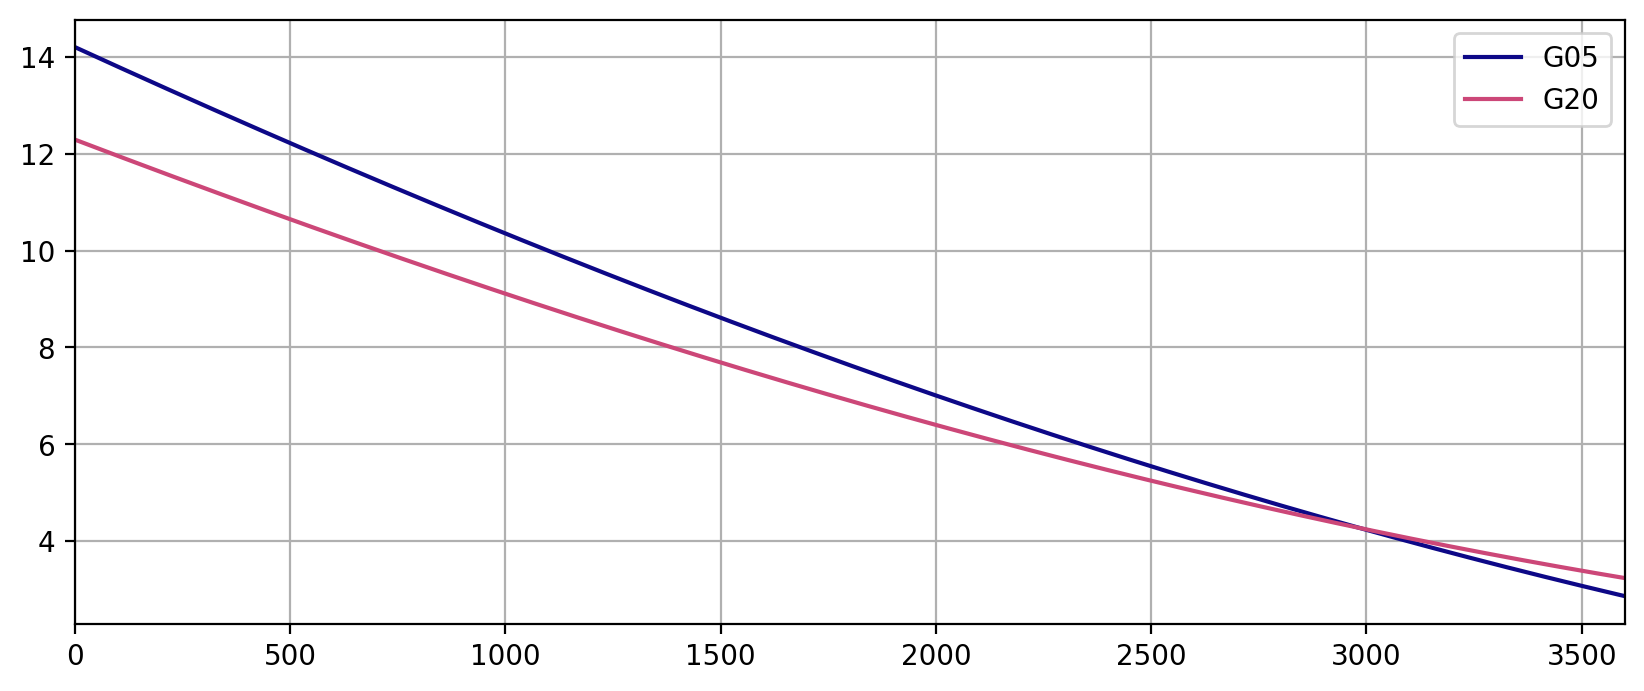

In [4]:
fig = plt.figure(figsize=(10, 4), dpi=200)
ax = fig.add_subplot(111)

sat_id_list = ['G05', 'G20']
sat_colors = [plt.cm.plasma(i / len(sat_id_list)) for i in range(len(sat_id_list))]
time_plot = time - time[0]
for i, sat_id in enumerate(sat_id_list):
    sat_elev = sat_sky[sat_id][:, 1]
    ax.plot(time_plot, sat_elev, color=sat_colors[i], label=sat_id)
ax.legend()
ax.grid()
ax.set_xlim(time_plot[[0, -1]])
plt.show()

In [4]:
from utilities.gpsl1ca import acquire_GPS_L1CA, sample_GPS_L1CA_signal, get_GPS_L1CA_signal_dict
sat_id = 'G30'
prn = int(sat_id[1:])
signal = get_GPS_L1CA_signal_dict(prn)
signal_params = signal.copy()
signal['sample_signal'] = functools.partial(sample_GPS_L1CA_signal, signal['prn'])

c_acq, f_acq, n_acq = acquire_GPS_L1CA(source, prn, start_time)

# Plot acquisition results (GPS L1) to validate
fig = plt.figure(figsize=(12, 12), dpi=200)
gspec = mpl.gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1], hspace=.3)
axes = [fig.add_subplot(gspec[i, 0]) for i in range(3)]
ax1, ax2, ax3 = axes

extent = [*c_acq['code_phase_bins'][[0, -1]], *c_acq['doppler_bins'][[0, -1]]]
ax1.imshow(c_acq['correlation'], extent=extent, aspect='auto', interpolation='nearest')
ax1.set_xlim(c_acq['rho0'] - 20, c_acq['rho0'] + 20)
ax1.set_ylabel('Doppler [Hz]')
ax1.set_xlabel('Code Phase [chips]')

ax2.plot(f_acq['phases'], color='k')
ax2.set_xlim(0, len(f_acq['phases']))
ax2.grid()
ax2.set_xlabel('Block #')
ax2.set_ylabel('Phase [rad]')

ax3.bar(numpy.arange(20), n_acq['shift_correlation'], color='k')
ax3.set_xlim(0, len(n_acq['shift_correlation']))
ax3.grid()
ax3.set_xlabel('Block #')
ax3.set_ylabel('Correlation')

fig.align_labels()

plt.show()

NameError: name 'source' is not defined

In [18]:
output_dir = '/media/share/brianbw/projects/2022-haleakala-tracking/ursi-results-v1/'
os.makedirs(output_dir, exist_ok=True)

tracking_options = {
    'PLL_ord': 3,
    'chip_delta': .5,
    'chip_offsets_start': - .5,
    'chip_offsets_stop': 1,
    
    'epl_chip_spacing': .5,
    
    'track_data_channel': True,
    'use_arctan_discr': False,
    
    'use_carrier_aiding': True,
    'sig2_dG': 5,
    'sig2_ddG': 2,
    'sig2_dddG': 1,
    'sig2_dI': 0,
    'sig2_dMr': 5,
    'sig2_dMp': 1,
}

data_dirs = ['/media/datastore/8HHBD3RH']
# data_dirs = ['/media/datastore/8DKTG4TH']
file_info_list = get_haleakala_file_info_list(data_dirs)

# get just GPS L1 (RX6, RX7) at 4:00 UT for the first day (June 6th)
file_info_list_GPSL1 = sorted([fi for fi in file_info_list if fi['rx_id'] in ['RX6', 'RX7']], key=lambda info: info['filename'])
file_info_list_GPSL1 = file_info_list_GPSL1[:2]

file_info_list_GPSL2 = sorted([fi for fi in file_info_list if fi['rx_id'] in ['RX5', 'RX8']], key=lambda info: info['filename'])
file_info_list_GPSL2 = file_info_list_GPSL2[:2]

In [19]:
file_info_list_GPSL1, file_info_list_GPSL2

[{'directory': '/media/datastore/8HHBD3RH',
  'filename': '20210606_160000_010001_HI_RX6.sc8',
  'file_dt': datetime.datetime(2021, 6, 6, 16, 0),
  'file_duration': 3601,
  'rx_id': 'RX6'},
 {'directory': '/media/datastore/8HHBD3RH',
  'filename': '20210606_160000_010001_HI_RX7.sc8',
  'file_dt': datetime.datetime(2021, 6, 6, 16, 0),
  'file_duration': 3601,
  'rx_id': 'RX7'}]

In [ ]:
sat_id_list = ['G05', 'G30']
rx_ecf = geo2ecf(HALEAKALA_APPROX_RX_GEO)

for file_info in file_info_list:
    
    # setup source
    source_template = get_haleakala_source_template(file_info['rx_id'])
    source = file_source_setup(filepath=os.path.join(file_info['directory'], file_info['filename']), **source_template)

    # get satellite positions / elevations
    start_gpst = dt2gpst(file_info['file_dt'])
    time = start_gpst + numpy.arange(0, file_info['file_duration'], 1)
    sat_ecf = compute_satellite_ecf_position(time, user_data_dir)
    sat_sky = {sat_id: ecf2sky(rx_ecf, sat_ecf[sat_id]) for sat_id in sat_ecf.keys()}
    sat_ids = sorted(list(set(gps_sat_ids) & set(sat_sky.keys())))

    sat_segments_of_interest = get_sat_segments_of_interest(sat_ids, time, sat_sky)
    for sat_id, i_start, i_end in sat_segments_of_interest:

        start_time = time[i_start] - time[0]
        duration = time[i_end - 1] - time[i_start]
#         duration = 2

        prn = int(sat_id[1:])
        signal = get_GPS_L1CA_signal_dict(prn)
        signal_params = signal.copy()
        signal['sample_signal'] = functools.partial(sample_GPS_L1CA_signal, signal['prn'])

        output_filename = os.path.basename(source['filepath']).split('.')[0] + \
            '__tracking-results__{0}_{1:3.3f}_{2:4.3f}.h5'.format(sat_id, start_time, duration)
        output_filepath = os.path.join(output_dir, output_filename)
        if os.path.exists(output_filepath) and not overwrite:
            continue
        
        print(sat_id)
        c_acq, f_acq, n_acq = acquire_GPS_L1CA(source, prn, start_time)
        args, outputs = track(source, signal, start_time, 1e-3, n_acq['rho0'], f_acq['phi0'], f_acq['doppler'], duration, **tracking_options)
        with h5py.File(output_filepath, 'w') as f:
            write_dict_to_hdf5({'signal_params': signal_params, 'start_time': time[i_start],
                                'rx_id': file_info['rx_id'], 'c_acq': c_acq, 'f_acq': f_acq, 'n_acq': n_acq,
                                'args': args, 'outputs': outputs}, f)
        print(output_filepath)

G02
Code Phase: 83.272 chips 	Doppler Freq: 2144.965 	 C/N0: 46.956
Phi0: -0.603 rad 	Doppler Freq: 2089.648 	 Dopp. Delta: -55.317
Data Bit Phase: 0.000
 3599900 / 3600000
/media/share/brianbw/projects/2022-haleakala-tracking/track-all/20210606_160000_010001_HI_RX6__tracking-results__G02_0.000_3600.000.h5
G05
Code Phase: 342.296 chips 	Doppler Freq: -2055.035 	 C/N0: 50.823
Phi0: -0.208 rad 	Doppler Freq: -2067.510 	 Dopp. Delta: -12.475
Data Bit Phase: 19.000
 0874200 / 2699000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1776000 / 2699000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2671800 / 2699000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0857800 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1746500 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2365400 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2644100 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3263300 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3547800 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0559200 / 2614000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0838500 / 2614000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2613900 / 2614000
/media/share/brianbw/projects/2022-haleakala-tracking/track-all/20210606_160000_010001_HI_RX6__tracking-results__G20_0.000_2614.000.h5
G25
Code Phase: 295.033 chips 	Doppler Freq: 2344.965 	 C/N0: 45.929
Phi0: -0.098 rad 	Doppler Freq: 2385.283 	 Dopp. Delta: 40.319
Data Bit Phase: 17.000
 1321100 / 2745000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2259600 / 2745000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2744900 / 2745000
/media/share/brianbw/projects/2022-haleakala-tracking/track-all/20210606_160000_010001_HI_RX6__tracking-results__G25_855.000_2745.000.h5
G30
Code Phase: 249.817 chips 	Doppler Freq: 2144.965 	 C/N0: 39.219
Phi0: -1.005 rad 	Doppler Freq: 2185.344 	 Dopp. Delta: 40.379
Data Bit Phase: 0.000
 0247700 / 1581000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1168500 / 1581000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0509800 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1436100 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2363100 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3292900 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0612000 / 2699000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1533100 / 2699000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2698900 / 2699000
/media/share/brianbw/projects/2022-haleakala-tracking/track-all/20210606_160000_010001_HI_RX7__tracking-results__G05_0.000_2699.000.h5
G06
Code Phase: 669.656 chips 	Doppler Freq: 1944.965 	 C/N0: 41.226
Phi0: 0.764 rad 	Doppler Freq: 1933.097 	 Dopp. Delta: -11.867
Data Bit Phase: 19.000
 0929700 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1833600 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2432700 / 3600000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3599900 / 3600000
/media/share/brianbw/projects/2022-haleakala-tracking/track-all/20210606_160000_010001_HI_RX7__tracking-results__G06_0.000_3600.000.h5
G20
Code Phase: 244.702 chips 	Doppler Freq: -1855.035 	 C/N0: 55.891
Phi0: -0.802 rad 	Doppler Freq: -1814.178 	 Dopp. Delta: 40.857
Data Bit Phase: 0.000
 0207100 / 2614000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1626000 / 2614000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2613900 / 2614000
/media/share/brianbw/projects/2022-haleakala-tracking/track-all/20210606_160000_010001_HI_RX7__tracking-results__G20_0.000_2614.000.h5
G25
Code Phase: 295.033 chips 	Doppler Freq: 2344.965 	 C/N0: 47.926
Phi0: -3.974 rad 	Doppler Freq: 2390.904 	 Dopp. Delta: 45.939
Data Bit Phase: 17.000
 1993200 / 2745000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2445000 / 2745000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0179000 / 1581000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0767000 / 1581000